In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.vision import *

In [24]:
bs = 4

In [25]:
path = untar_data(URLs.PETS)/'images'
path

WindowsPath('C:/Users/Tim/.fastai/data/oxford-iiit-pet/images')

In [26]:
path.ls()

[WindowsPath('C:/Users/Tim/.fastai/data/oxford-iiit-pet/images/Abyssinian_1.jpg'),
 WindowsPath('C:/Users/Tim/.fastai/data/oxford-iiit-pet/images/Abyssinian_10.jpg'),
 WindowsPath('C:/Users/Tim/.fastai/data/oxford-iiit-pet/images/Abyssinian_100.jpg'),
 WindowsPath('C:/Users/Tim/.fastai/data/oxford-iiit-pet/images/Abyssinian_100.mat'),
 WindowsPath('C:/Users/Tim/.fastai/data/oxford-iiit-pet/images/Abyssinian_101.jpg'),
 WindowsPath('C:/Users/Tim/.fastai/data/oxford-iiit-pet/images/Abyssinian_101.mat'),
 WindowsPath('C:/Users/Tim/.fastai/data/oxford-iiit-pet/images/Abyssinian_102.jpg'),
 WindowsPath('C:/Users/Tim/.fastai/data/oxford-iiit-pet/images/Abyssinian_102.mat'),
 WindowsPath('C:/Users/Tim/.fastai/data/oxford-iiit-pet/images/Abyssinian_103.jpg'),
 WindowsPath('C:/Users/Tim/.fastai/data/oxford-iiit-pet/images/Abyssinian_104.jpg'),
 WindowsPath('C:/Users/Tim/.fastai/data/oxford-iiit-pet/images/Abyssinian_105.jpg'),
 WindowsPath('C:/Users/Tim/.fastai/data/oxford-iiit-pet/images/Abyss

In [27]:
tfms = get_transforms(flip_vert=True, 
                      max_rotate=20, max_zoom=1.3, max_lighting=0.4, 
                     max_warp=0.4, p_affine=1., p_lighting=1.)

In [28]:
src = ImageList.from_folder(path).split_by_rand_pct(0.2, seed=2)

In [29]:
# labels  from regular expression
def get_data(size, bs, padding_mode='reflection'):
    return (src.label_from_re(r'([^/]+)_\d+.jpg$')
           .transform(tfms, size=size, padding_mode=padding_mode)
           .databunch(bs=bs).normalize(imagenet_stats))

In [30]:
data = get_data(224, bs)

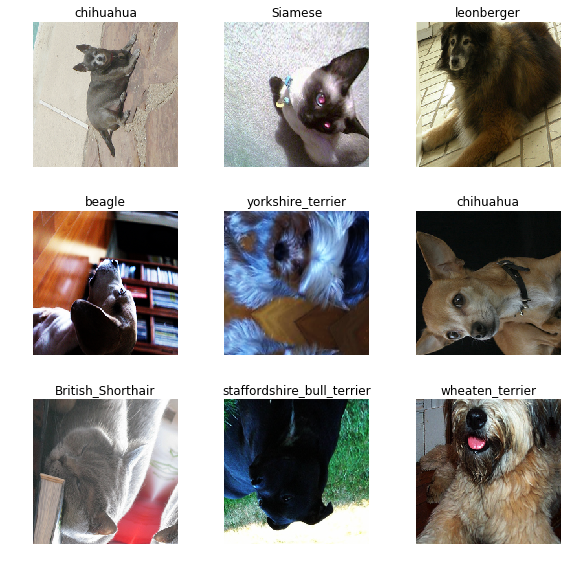

In [10]:
data.show_batch(rows=3, figsize=(8,8))

#### Here default 'reflection' mode is used, compare with padding with 'zeros' above, we don't have black empty space in augmented pictures

In [11]:
data = get_data(224,bs)

In [12]:
data.c

37

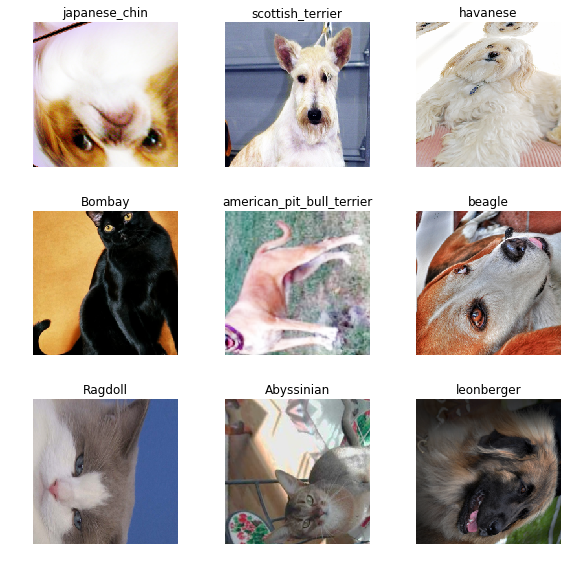

In [13]:
data.show_batch(rows=3, figsize=(8,8))

## Train a model

In [14]:
gc.collect()

14851

from cnn_learner doc:

### Transfer learning
Transfer learning is a technique where you use a model trained on a very large dataset (usually ImageNet in computer vision) and then adapt it to your own dataset. The idea is that it has learned to recognize many features on all of this data, and that you will benefit from this knowledge, especially if your dataset is small, compared to starting from a randomly initialized model. It has been proved in this article on a wide range of tasks that transfer learning nearly always give better results.

In practice, you need to change the last part of your model to be adapted to your own number of classes. Most convolutional models end with a few linear layers (a part will call head). The last convolutional layer will have analyzed features in the image that went through the model, and the job of the head is to convert those in predictions for each of our classes. In transfer learning we will keep all the convolutional layers (called the body or the backbone of the model) with their weights pretrained on ImageNet but will define a new head initialized randomly.

Then we will train the model we obtain in two phases: first we freeze the body weights and only train the head (to convert those analyzed features into predictions for our own data), then we unfreeze the layers of the backbone (gradually if necessary) and fine-tune the whole model (possibly using differential learning rates).

The cnn_learner factory method helps you to automatically get a pretrained model from a given architecture with a custom head that is suitable for your data.

cnn_learner[source][test]
cnn_learner(data:DataBunch, base_arch:Callable, cut:Union[int, Callable]=None, pretrained:bool=True, lin_ftrs:Optional[Collection[int]]=None, ps:Floats=0.5, custom_head:Optional[Module]=None, split_on:Union[Callable, Collection[ModuleList], NoneType]=None, bn_final:bool=False, init='kaiming_normal_', concat_pool:bool=True, **kwargs:Any) → Learner

Build convnet style learner.

This method creates a Learner object from the data object and model inferred from it with the backbone given in arch. Specifically, it will cut the model defined by arch (randomly initialized if pretrained is False) at the last convolutional layer by default (or as defined in cut, see below) and add:

an AdaptiveConcatPool2d layer,
a Flatten layer,
blocks of [nn.BatchNorm1d, nn.Dropout, nn.Linear, nn.ReLU] layers.

In [31]:
learn = Learner(data, models.resnet34(), metrics=accuracy)
learn

Learner(data=ImageDataBunch;

Train: LabelList (5912 items)
x: ImageList
Image (3, 352, 352),Image (3, 352, 352),Image (3, 352, 352),Image (3, 352, 352),Image (3, 352, 352)
y: CategoryList
Abyssinian,Abyssinian,Abyssinian,Abyssinian,Abyssinian
Path: C:\Users\Tim\.fastai\data\oxford-iiit-pet\images;

Valid: LabelList (1478 items)
x: ImageList
Image (3, 352, 352),Image (3, 352, 352),Image (3, 352, 352),Image (3, 352, 352),Image (3, 352, 352)
y: CategoryList
american_pit_bull_terrier,staffordshire_bull_terrier,Abyssinian,Egyptian_Mau,Maine_Coon
Path: C:\Users\Tim\.fastai\data\oxford-iiit-pet\images;

Test: None, model=ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kerne

In [31]:
tlearn = cnn_learner(data, models.resnet34, metrics=accuracy, bn_final=True)
tlearn

Learner(data=ImageDataBunch;

Train: LabelList (5912 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Abyssinian,Abyssinian,Abyssinian,Abyssinian,Abyssinian
Path: C:\Users\Tim\.fastai\data\oxford-iiit-pet\images;

Valid: LabelList (1478 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
american_pit_bull_terrier,staffordshire_bull_terrier,Abyssinian,Egyptian_Mau,Maine_Coon
Path: C:\Users\Tim\.fastai\data\oxford-iiit-pet\images;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Con

In [21]:
tlearn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


In [ ]:
tlearn.recorder.plot()

In [17]:
tlearn.fit_one_cycle(3, slice(1e-2), pct_start=0.8)

epoch,train_loss,valid_loss,accuracy,time
0,2.507169,1.343189,0.753045,08:47
1,1.626267,0.434039,0.882273,10:11
2,1.349710,0.311597,0.910690,10:52


In [22]:
tlearn.save('224')

In [32]:
tlearn.load('224')

Learner(data=ImageDataBunch;

Train: LabelList (5912 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Abyssinian,Abyssinian,Abyssinian,Abyssinian,Abyssinian
Path: C:\Users\Tim\.fastai\data\oxford-iiit-pet\images;

Valid: LabelList (1478 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
american_pit_bull_terrier,staffordshire_bull_terrier,Abyssinian,Egyptian_Mau,Maine_Coon
Path: C:\Users\Tim\.fastai\data\oxford-iiit-pet\images;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Con

In [33]:
tlearn.unfreeze()
tlearn.fit_one_cycle(2, max_lr=slice(1e-6,1e-3), pct_start=0.8)

epoch,train_loss,valid_loss,accuracy,time
0,2.463286,0.442717,0.872124,08:46
1,2.452341,0.616864,0.808525,09:18


In [34]:
data = get_data(352,bs)
tlearn.data = data

In [35]:
tlearn.fit_one_cycle(2, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,accuracy,time
0,2.409718,0.512703,0.857916,15:30
1,2.376194,0.529606,0.863329,16:13


In [36]:
tlearn.save('352')

### Convolution kernel

In [37]:
data = get_data(352,16)

In [38]:
tlearn = cnn_learner(data, models.resnet34, metrics=error_rate, bn_final=True).load('352')

Category american_pit_bull_terrier

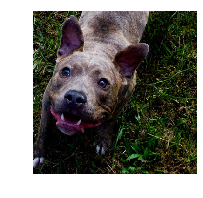

In [39]:
idx=0
x,y = data.valid_ds[idx]
x.show()
data.valid_ds.y[idx]

In [40]:
k = tensor([
    [0.  ,-5/3,1],
    [-5/3,-5/3,1],
    [1.  ,1   ,1],
]).expand(1,3,3,3)/6

In [41]:
k

tensor([[[[ 0.0000, -0.2778,  0.1667],
          [-0.2778, -0.2778,  0.1667],
          [ 0.1667,  0.1667,  0.1667]],

         [[ 0.0000, -0.2778,  0.1667],
          [-0.2778, -0.2778,  0.1667],
          [ 0.1667,  0.1667,  0.1667]],

         [[ 0.0000, -0.2778,  0.1667],
          [-0.2778, -0.2778,  0.1667],
          [ 0.1667,  0.1667,  0.1667]]]])

In [42]:
k.shape

torch.Size([1, 3, 3, 3])

In [43]:
t = data.valid_ds[0][0].data; t.shape

torch.Size([3, 352, 352])

In [44]:
t[None].shape

torch.Size([1, 3, 352, 352])

In [45]:
edge = F.conv2d(t[None], k)

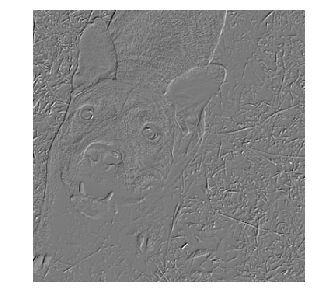

In [46]:
show_image(edge[0], figsize=(5,5));


In [49]:
tlearn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [50]:
print(tlearn.summary())

Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 176, 176]       9,408      False     
______________________________________________________________________
BatchNorm2d          [64, 176, 176]       128        True      
______________________________________________________________________
ReLU                 [64, 176, 176]       0          False     
______________________________________________________________________
MaxPool2d            [64, 88, 88]         0          False     
______________________________________________________________________
Conv2d               [64, 88, 88]         36,864     False     
______________________________________________________________________
BatchNorm2d          [64, 88, 88]         128        True      
______________________________________________________________________
ReLU                 [64, 88, 88]         0          False     
______________________________________________________________

### Heatmap

In [51]:
m = tlearn.model.eval();

In [52]:
xb,_ = data.one_item(x)
xb_im = Image(data.denorm(xb)[0])
xb = xb.cuda()

In [53]:
from fastai.callbacks.hooks import *

In [54]:
def hooked_backward(cat=y):
    with hook_output(m[0]) as hook_a: 
        with hook_output(m[0], grad=True) as hook_g:
            preds = m(xb)
            preds[0,int(cat)].backward()
    return hook_a,hook_g


In [55]:
hook_a,hook_g = hooked_backward()


In [56]:
acts  = hook_a.stored[0].cpu()
acts.shape

torch.Size([512, 11, 11])

In [57]:
avg_acts = acts.mean(0)
avg_acts.shape

torch.Size([11, 11])

In [58]:
def show_heatmap(hm):
    _,ax = plt.subplots()
    xb_im.show(ax)
    ax.imshow(hm, alpha=0.6, extent=(0,352,352,0),
              interpolation='bilinear', cmap='magma');

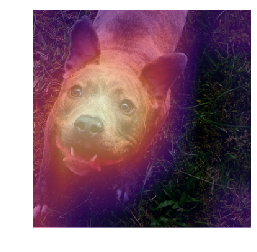

In [59]:
show_heatmap(avg_acts)